## Match winner prediction (cleaning + baseline model)

Goal: build a clean dataset from `data/raw_data.csv` and train a first baseline model to predict:
- **Home win / Draw / Away win**

Notes:
- This notebook focuses on **data cleaning + feature engineering**.
- It uses **inline plots** (no image files are written).
- Your football-data.org plan may limit older seasons; the modeling will work with whatever is present in `raw_data.csv`.


In [7]:
pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SK

In [1]:
# If you don't have these yet, uncomment the next line:
# !python3 -m pip install -q pandas matplotlib scikit-learn

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

REPO_ROOT = Path.cwd()
if REPO_ROOT.name == "code":
    REPO_ROOT = REPO_ROOT.parent

CSV_PATH = REPO_ROOT / "data" / "raw_data.csv"
assert CSV_PATH.exists(), f"Missing {CSV_PATH}. Run: python3 code/main.py"

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (10, 4)


In [2]:
# Load + basic cleaning

df = pd.read_csv(CSV_PATH)
print("rows:", len(df), "cols:", len(df.columns))
df.head(3)


rows: 1140 cols: 22


,area_name,awayTeam_id,awayTeam_name,competition_code,competition_id,competition_name,group,homeTeam_id,homeTeam_name,match_id,matchday,raw_json,referees_json,score_duration,score_fullTime_away,score_fullTime_home,score_winner,season_endDate,season_startDate,stage,status,utcDate
0,Spain,87,Rayo Vallecano de Madrid,PD,2014,Primera Division,NaN,267,UD Almería,438482,1,"{""area"":{""id"":2224,""name"":""Spain"",""code"":""ESP""...","[{""id"": 80747, ""name"": ""Javier Alberola Rojas""...",REGULAR,2.0,0.0,AWAY_TEAM,2024-05-26,2023-08-13,REGULAR_SEASON,FINISHED,2023-08-11T17:30:00Z
1,Spain,95,Valencia CF,PD,2014,Primera Division,NaN,559,Sevilla FC,438479,1,"{""area"":{""id"":2224,""name"":""Spain"",""code"":""ESP""...","[{""id"": 207080, ""name"": ""José Sánchez Martínez...",REGULAR,2.0,1.0,AWAY_TEAM,2024-05-26,2023-08-13,REGULAR_SEASON,FINISHED,2023-08-11T20:00:00Z
2,Spain,298,Girona FC,PD,2014,Primera Division,NaN,92,Real Sociedad de Fútbol,438481,1,"{""area"":{""id"":2224,""name"":""Spain"",""code"":""ESP""...","[{""id"": 214213, ""name"": ""Francisco Hernández M...",REGULAR,1.0,1.0,DRAW,2024-05-26,2023-08-13,REGULAR_SEASON,FINISHED,2023-08-12T15:00:00Z


In [3]:
# Ensure key columns exist (exporter writes these)
required = [
    "utcDate",
    "status",
    "homeTeam_name",
    "awayTeam_name",
    "score_fullTime_home",
    "score_fullTime_away",
]
missing = [c for c in required if c not in df.columns]
assert not missing, f"CSV missing expected columns: {missing}"

# Parse timestamp
_df = df.copy()
_df["utcDate"] = pd.to_datetime(_df["utcDate"], errors="coerce", utc=True)
_df = _df.dropna(subset=["utcDate", "homeTeam_name", "awayTeam_name"])

# Coerce scores to numeric
_df["score_fullTime_home"] = pd.to_numeric(_df["score_fullTime_home"], errors="coerce")
_df["score_fullTime_away"] = pd.to_numeric(_df["score_fullTime_away"], errors="coerce")

# Keep only finished matches with known full-time scores
finished = _df[_df["status"].eq("FINISHED")].copy()
finished = finished.dropna(subset=["score_fullTime_home", "score_fullTime_away"]).copy()

# Target label: H / D / A
finished["target"] = np.where(
    finished["score_fullTime_home"] > finished["score_fullTime_away"],
    "H",
    np.where(
        finished["score_fullTime_home"] < finished["score_fullTime_away"],
        "A",
        "D",
    ),
)

finished = finished.sort_values("utcDate").reset_index(drop=True)

print("finished w/ scores:", len(finished))
finished[["utcDate", "homeTeam_name", "awayTeam_name", "score_fullTime_home", "score_fullTime_away", "target"]].head(5)


finished w/ scores: 944


,utcDate,homeTeam_name,awayTeam_name,score_fullTime_home,score_fullTime_away,target
0,2023-08-11 17:30:00+00:00,UD Almería,Rayo Vallecano de Madrid,0.0,2.0,A
1,2023-08-11 20:00:00+00:00,Sevilla FC,Valencia CF,1.0,2.0,A
2,2023-08-12 15:00:00+00:00,Real Sociedad de Fútbol,Girona FC,1.0,1.0,D
3,2023-08-12 17:30:00+00:00,UD Las Palmas,RCD Mallorca,1.0,1.0,D
4,2023-08-12 19:30:00+00:00,Athletic Club,Real Madrid CF,0.0,2.0,A


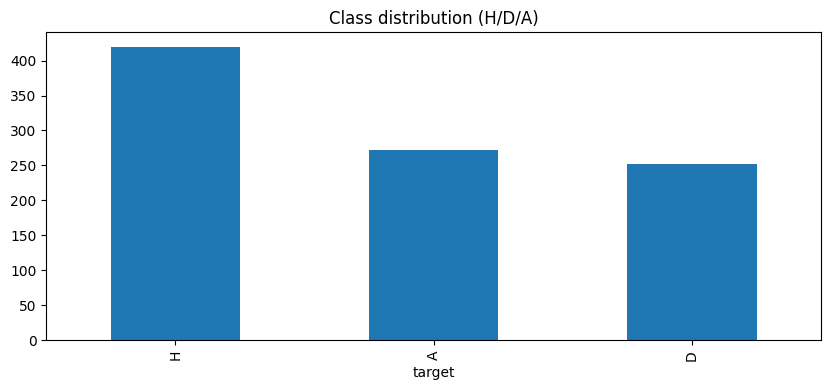

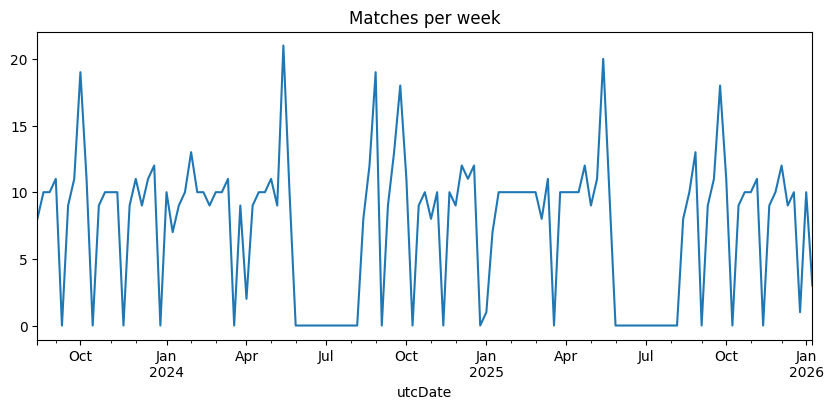

In [4]:
# Quick sanity checks / EDA (inline)

finished["target"].value_counts().plot(kind="bar", title="Class distribution (H/D/A)")
plt.show()

# Matches over time
finished.set_index("utcDate")["match_id"].resample("W").count().plot(title="Matches per week")
plt.show()


In [5]:
# Feature engineering: rolling team form (last N games) computed *only from past matches*

N = 5  # rolling window

# Build long format: one row per team per match
long = pd.concat(
    [
        finished[["utcDate", "match_id", "homeTeam_name", "awayTeam_name", "score_fullTime_home", "score_fullTime_away"]]
        .rename(columns={"homeTeam_name": "team", "awayTeam_name": "opponent"})
        .assign(is_home=1, goals_for=lambda x: x["score_fullTime_home"], goals_against=lambda x: x["score_fullTime_away"]),
        finished[["utcDate", "match_id", "awayTeam_name", "homeTeam_name", "score_fullTime_away", "score_fullTime_home"]]
        .rename(columns={"awayTeam_name": "team", "homeTeam_name": "opponent"})
        .assign(is_home=0, goals_for=lambda x: x["score_fullTime_away"], goals_against=lambda x: x["score_fullTime_home"]),
    ],
    ignore_index=True,
)

long["points"] = np.where(
    long["goals_for"] > long["goals_against"], 3,
    np.where(long["goals_for"] < long["goals_against"], 0, 1),
)

long = long.sort_values(["team", "utcDate"]).reset_index(drop=True)

# Rolling stats excluding current match (shift by 1)
for col in ["points", "goals_for", "goals_against"]:
    long[f"{col}_avg_last{N}"] = (
        long.groupby("team")[col]
        .transform(lambda s: s.shift(1).rolling(N, min_periods=1).mean())
    )

# Split back into home/away feature tables
home_feats = long[long["is_home"].eq(1)][
    ["match_id", "points_avg_last5", "goals_for_avg_last5", "goals_against_avg_last5"]
].rename(
    columns={
        "points_avg_last5": "home_points_avg_last5",
        "goals_for_avg_last5": "home_gf_avg_last5",
        "goals_against_avg_last5": "home_ga_avg_last5",
    }
)

away_feats = long[long["is_home"].eq(0)][
    ["match_id", "points_avg_last5", "goals_for_avg_last5", "goals_against_avg_last5"]
].rename(
    columns={
        "points_avg_last5": "away_points_avg_last5",
        "goals_for_avg_last5": "away_gf_avg_last5",
        "goals_against_avg_last5": "away_ga_avg_last5",
    }
)

model_df = finished.merge(home_feats, on="match_id", how="left").merge(away_feats, on="match_id", how="left")

# Simple deltas
model_df["points_diff_last5"] = model_df["home_points_avg_last5"] - model_df["away_points_avg_last5"]
model_df["gf_diff_last5"] = model_df["home_gf_avg_last5"] - model_df["away_gf_avg_last5"]
model_df["ga_diff_last5"] = model_df["home_ga_avg_last5"] - model_df["away_ga_avg_last5"]

features = [
    "home_points_avg_last5",
    "away_points_avg_last5",
    "points_diff_last5",
    "gf_diff_last5",
    "ga_diff_last5",
]

model_df[features].head()


,home_points_avg_last5,away_points_avg_last5,points_diff_last5,gf_diff_last5,ga_diff_last5
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
